##### Initial segmentation will use the [MaskRCNN model with the ResNet-50-FCN](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html#torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights) and the DeepBlueberry Dataset

In [1]:
import os
import cv2 as cv
import numpy as np

import torch
from torchvision import datasets
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as M

BASE_DIR = '../img/instancesegmentation'
IMAGES_DIR = BASE_DIR + '/images/'
MASKS_DIR = BASE_DIR + '/masks/'
TEST_DIR = BASE_DIR + '/test'

class BlueberryDataset(Dataset):
    def __init__(self, base_dir, img_dir, mask_dir, transform=None):
        self.images = []
        self.masks = []
        self.transform = transform
        self.to_tensor = T.Compose([T.ToTensor()])
        for img_file in os.listdir(img_dir):
            self.images.append(os.path.join(img_dir, img_file))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = cv.imread(self.images[index])
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        mask = cv.imread(self.masks[index])
        mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
        
        return image, mask
    
class BlueberryTestDataset(Dataset):
    def __init__(self, base_dir, img_dir, transform=None):
        self.images = []
        self.transform = transform
        self.to_tensor = T.Compose([T.ToTensor()])
    
        for img_file in os.listdir(img_dir):
            self.images.append(os.path.join(img_dir, img_file))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = cv.imread(self.images[index])
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        transformed = self.transform(image=image)
    
        image = transformed['image']
        image = self.to_tensor(image)
    
        return image

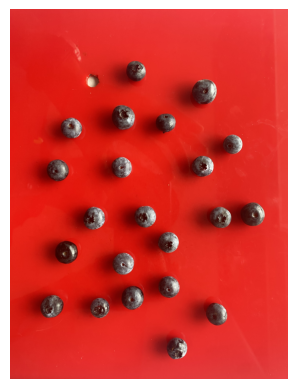

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

# Load a ripe image
image_path = '../img/test_set/ripe/ripe-1.png'
image = Image.open(image_path).convert("RGB")

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()